In [11]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, BartForConditionalGeneration, BartConfig
from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration, T5Config
from transformers import GemmaTokenizerFast, GemmaForCausalLM, GemmaConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# visualization
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/NanumFont/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Tokenizer 정의

In [2]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
model_dir = "lcw99/t5-base-korean-text-summary"
tokenizer = T5TokenizerFast.from_pretrained(model_dir) 

# https://huggingface.co/paust/pko-t5-base
# transformers 의 API 를 사용하여 접근 가능합니다. 
# tokenizer 를 사용할때는 T5Tokenizer 가 아니라 T5TokenizerFast 를 사용해주십시오. 
# model 은 T5ForConditionalGeneration 를 그대로 활용하시면 됩니다.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
print(tokenizer.eos_token)
print(tokenizer.unk_token)
print(tokenizer.pad_token)

</s>
<pad>
<pad>


In [4]:
tokenizer.unk_token = '<unk>'
print(tokenizer.unk_token)

<unk>


# Config 정의

In [5]:
config_data = {
    "general": {
        "data_path": "your_path", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": f"{model_dir}", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": "./" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 1000,
        "decoder_max_len": 125,
        # "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        "unk_token": f"{tokenizer.unk_token}",
        "pad_token": f"{tokenizer.pad_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#Person4#', '#Person5#', '#Person6#', '#Person7#',
                           '#DateOfBirth#', '#CarNumber#', '#Email#', '#CardNumber#', '#Address#', '#SSN#', '#PhoneNumber#', '#PassportNumber#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 50,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 4, # 50
        "per_device_eval_batch_size": 32, # 32
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps":32, # 몇 개의 작은 배치를 합쳐서 큰 배치처럼 처리할지를 결정하는 파라미터: 메모리 제한 극복, 더 나은 성능
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 7,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 125,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 5, # 3
        "early_stopping_threshold": 0.0001, # 0.001
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": "entity_name",
        "project": "project_name",
        "name": "name"
    },
    "inference": {
        "ckt_path": "model ckt path", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "generate_max_length": 125,
        "num_beams": 4,
        "batch_size" : 32, # 32
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.eos_token}", f"{tokenizer.unk_token}", f"{tokenizer.pad_token}"]
    }
}

In [6]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = "./config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

In [7]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

In [8]:
# 이곳에 사용자가 저장한 데이터 dir 설정하기
loaded_config['general']['data_path'] = "../../data"

실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.

Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [9]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train_regex.csv'))
display(train_df.tail())

# dev data의 구조와 내용을 확인합니다.
dev_df = pd.read_csv(os.path.join(data_path,'dev_regex.csv'))
display(dev_df.tail())

# test data의 구조와 내용을 확인합니다.
test_df = pd.read_csv(os.path.join(data_path,'test.csv'))
display(test_df.tail())

# train, dev, test 길이 확인
print(train_df.shape[0], dev_df.shape[0], test_df.shape[0])

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...,탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....,누군가를 태우다
12453,train_12456,#Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...,#Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...,컨퍼런스 센터
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.,차 렌트
12455,train_12458,#Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...,#Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...,실직
12456,train_12459,"#Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...",#Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...,짐 싸기


,fname,dialogue,summary,topic
494,dev_495,#Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...,#Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...,새해
495,dev_496,"#Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...",#Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Person2#...,사랑에 빠지다
496,dev_497,"#Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...",#Person2#의 차에서 이상한 소리가 납니다. #Person1#는 브레이크를 교...,소음
497,dev_498,"#Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...",#Person2#님이 아마존 고객 서비스에 전화하여 아마존에서 받은 책에 한 페이지...,빠진 페이지
498,dev_499,#Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...,#Person2#는 #Person1#에게 여름 휴가 동안 파티를 도와주는 회사에서 ...,여름 휴가


,fname,dialogue
494,test_495,"#Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할..."
495,test_496,#Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...
496,test_497,"#Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻..."
497,test_498,#Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...
498,test_499,"#Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ..."


12457 499 499


# 토큰 개수 확인

In [10]:
# 토큰화
special_tokens = loaded_config['tokenizer']['special_tokens']

special_tokens_dict={'additional_special_tokens':special_tokens}
tokenizer.add_special_tokens(special_tokens_dict)

dialogue_tokenizer = train_df['dialogue'].apply(lambda x: tokenizer(x))
summary_tokenizer = train_df['summary'].apply(lambda x: tokenizer(x))
topic_tokenizer = train_df['topic'].apply(lambda x: tokenizer(x))

dialogue_len = dialogue_tokenizer.apply(lambda x: len(x['input_ids']))
summary_len = summary_tokenizer.apply(lambda x: len(x['input_ids']))
topic_len = topic_tokenizer.apply(lambda x: len(x['input_ids']))

temp = dialogue_len.describe().reset_index()
temp0 = summary_len.describe().reset_index()
temp1 = topic_len.describe().reset_index()

temp.merge(temp0, on='index').merge(temp1, on='index')

,index,dialogue,summary,topic
0,count,12457.000000,12457.000000,12457.000000
1,mean,259.183913,48.042386,3.966766
2,std,137.861326,21.893168,1.749306
3,min,59.000000,11.000000,2.000000
4,25%,170.000000,33.000000,3.000000
5,50%,230.000000,44.000000,4.000000
6,75%,321.000000,59.000000,5.000000
7,max,1658.000000,279.000000,74.000000


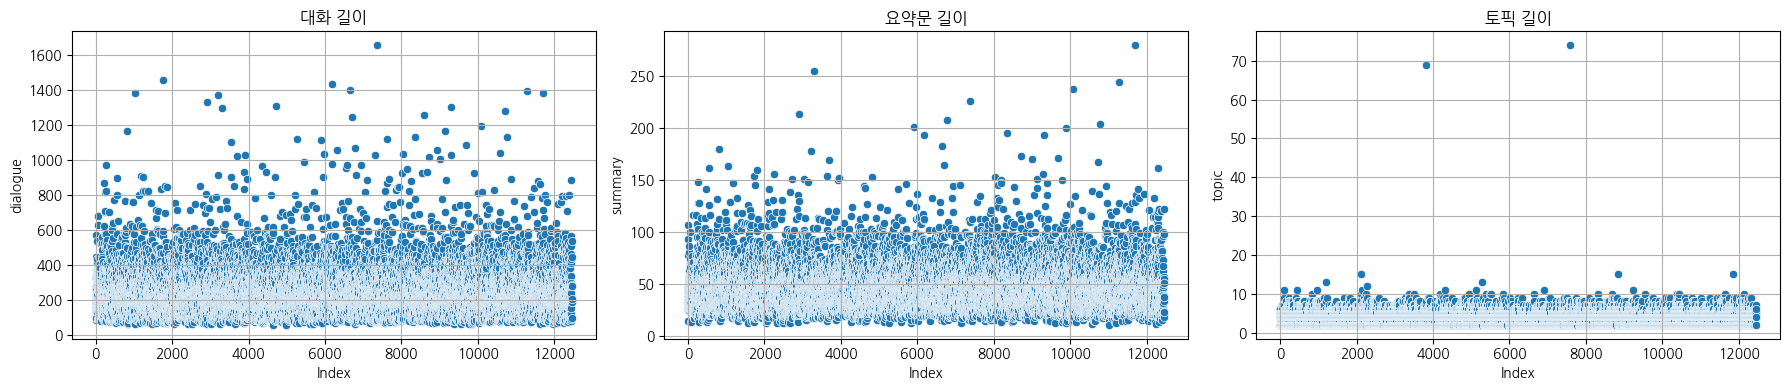

In [12]:
# scatter plot으로 분포 확인
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(data=dialogue_len.reset_index(), x=dialogue_len.index, y='dialogue')
plt.title('대화 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=summary_len.reset_index(), x=summary_len.index, y='summary')
plt.title('요약문 길이')
plt.xlabel('Index')
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=topic_len.reset_index(), x=topic_len.index, y='topic')
plt.title('토픽 길이')
plt.xlabel('Index')
plt.grid(True)

plt.tight_layout()
plt.show()